<ipython-input-7-ee67eda8983f>:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


데이터셋 이미지에서 특징 벡터 추출 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
데이터셋 특징 추출 완료!
쿼리 이미지: sample_data/sample1.jpg 처리 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


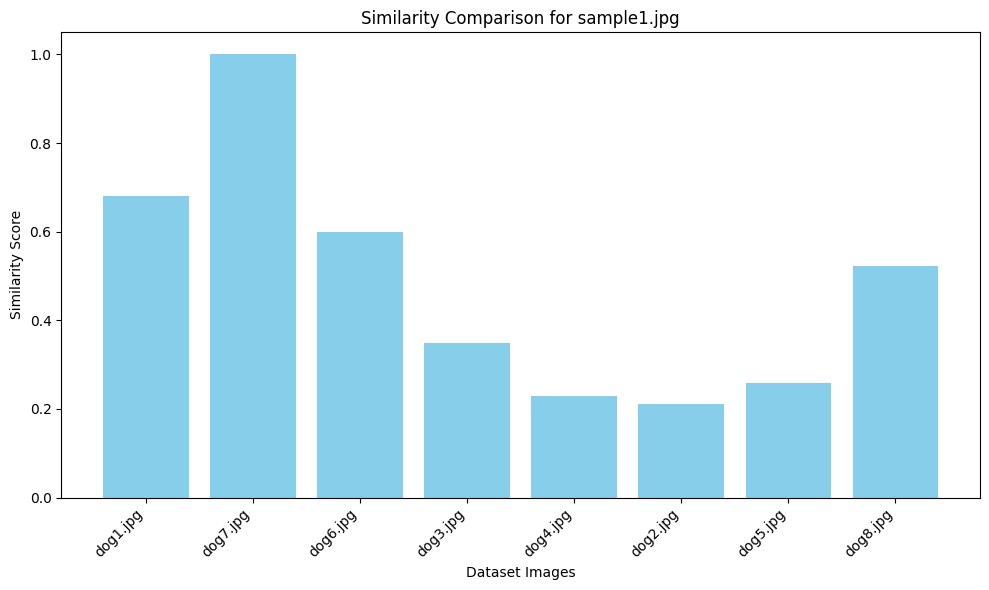

쿼리 이미지: sample_data/sample2.jpg 처리 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


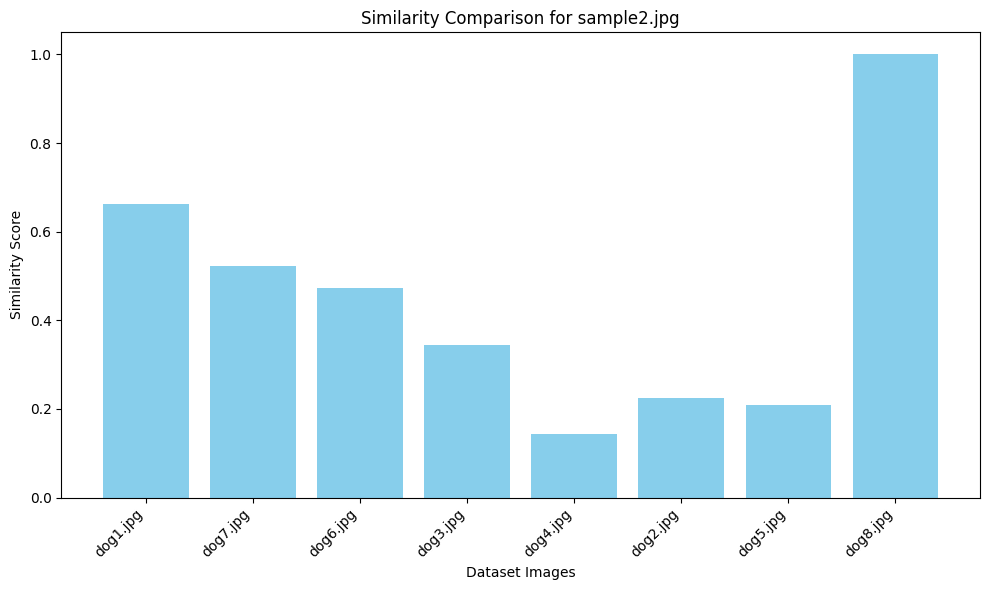

쿼리 이미지: sample_data/sample3.jpg 처리 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


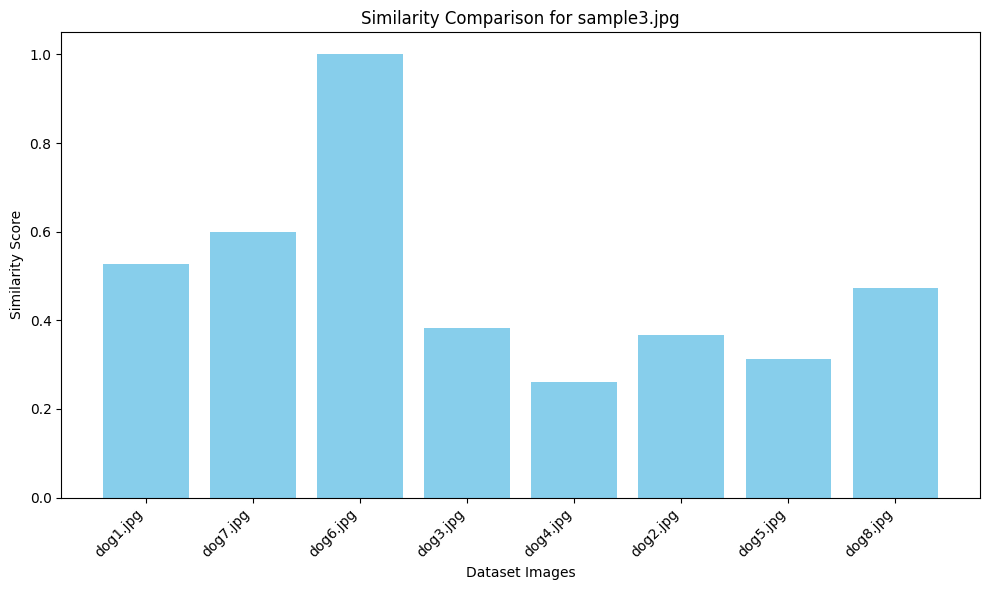


유사도 비교 결과:
               Query Image  dog1.jpg  dog7.jpg  dog6.jpg  dog3.jpg  dog4.jpg  \
0  sample_data/sample1.jpg  0.681668  1.000000  0.600231  0.348659  0.228818   
1  sample_data/sample2.jpg  0.661502  0.523440  0.472761  0.344264  0.142660   
2  sample_data/sample3.jpg  0.526344  0.600231  1.000000  0.382768  0.260109   

   dog2.jpg  dog5.jpg  dog8.jpg  
0  0.211826  0.258723  0.523440  
1  0.224454  0.209883  1.000000  
2  0.366177  0.312686  0.472761  


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd
import os
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# 이미지 전처리 함수
def preprocess_image(image_path, target_size=(224, 224)):
    """
    이미지를 로드하고 모델 입력 형식으로 변환합니다.
    """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# 특징 벡터 추출 함수
def extract_features(model, image_path):
    """
    주어진 이미지를 통해 특징 벡터를 추출합니다.
    """
    img = preprocess_image(image_path)
    features = model.predict(img)
    return features.flatten()

# 유사도 계산 함수
def calculate_similarities(query_features, dataset_features):
    """
    데이터셋의 모든 이미지와 쿼리 이미지 간 유사도를 계산합니다.
    """
    similarities = [1 - cosine(query_features, features) for features in dataset_features]
    return similarities

# 그래프 시각화 함수
def plot_similarities(query_image, dataset_image_names, similarities):
    """
    유사도 점수를 막대그래프로 시각화합니다.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(dataset_image_names, similarities, color='skyblue')
    plt.xlabel('Dataset Images')
    plt.ylabel('Similarity Score')
    plt.title(f'Similarity Comparison for {query_image}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 모델 초기화 (MobileNetV2 사용)
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# sample 이미지 경로 리스트
sample_image_paths = [
    "sample_data/sample1.jpg",
    "sample_data/sample2.jpg",
    "sample_data/sample3.jpg"
]

# dataset 폴더 경로
dataset_dir = "dataset"
dataset_image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir) if fname.endswith(".jpg")]

# 데이터셋 이미지 특징 추출
print("데이터셋 이미지에서 특징 벡터 추출 중...")
dataset_features = [extract_features(base_model, path) for path in dataset_image_paths]
print("데이터셋 특징 추출 완료!")

# 결과 저장을 위한 DataFrame
all_results = []

# 각 sample 이미지를 dataset 이미지들과 비교
for sample_image_path in sample_image_paths:
    print(f"쿼리 이미지: {sample_image_path} 처리 중...")

    # Query 이미지 특징 추출
    query_features = extract_features(base_model, sample_image_path)

    # 모든 dataset 이미지와의 유사도 계산
    similarities = calculate_similarities(query_features, dataset_features)

    # 유사도 결과를 저장
    results = {
        "Query Image": sample_image_path,
        **{os.path.basename(dataset_image_paths[i]): similarities[i] for i in range(len(dataset_image_paths))}
    }
    all_results.append(results)

    # 그래프 출력
    plot_similarities(
        query_image=os.path.basename(sample_image_path),
        dataset_image_names=[os.path.basename(path) for path in dataset_image_paths],
        similarities=similarities
    )

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame(all_results)

# 결과 출력
print("\n유사도 비교 결과:")
print(df_results)

# CSV 파일로 저장 (선택 사항)
df_results.to_csv("similarity_results.csv", index=False)
